In [1]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import os
cropped_img_dirs = []
for entry in os.scandir("./dataset/cropped/"):
    if entry.is_dir():
        cropped_img_dirs.append(entry.path)
cropped_img_dirs

['./dataset/cropped/cristiano ronaldo',
 './dataset/cropped/david beckham',
 './dataset/cropped/gareth bale',
 './dataset/cropped/kylian mbappe',
 './dataset/cropped/lionel messi',
 './dataset/cropped/luis suarez',
 './dataset/cropped/mohamed salah',
 './dataset/cropped/neymar jr',
 './dataset/cropped/thomas muller',
 './dataset/cropped/zlatan ibrahimovic']

In [3]:
player_file_names_dict = {}
for img_dir in cropped_img_dirs:
    player_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    player_file_names_dict[player_name] = file_list
player_file_names_dict

{'cristiano ronaldo': ['./dataset/cropped/cristiano ronaldo\\cristiano ronaldo1.png',
  './dataset/cropped/cristiano ronaldo\\cristiano ronaldo10.png',
  './dataset/cropped/cristiano ronaldo\\cristiano ronaldo11.png',
  './dataset/cropped/cristiano ronaldo\\cristiano ronaldo12.png',
  './dataset/cropped/cristiano ronaldo\\cristiano ronaldo13.png',
  './dataset/cropped/cristiano ronaldo\\cristiano ronaldo14.png',
  './dataset/cropped/cristiano ronaldo\\cristiano ronaldo15.png',
  './dataset/cropped/cristiano ronaldo\\cristiano ronaldo16.png',
  './dataset/cropped/cristiano ronaldo\\cristiano ronaldo17.png',
  './dataset/cropped/cristiano ronaldo\\cristiano ronaldo18.png',
  './dataset/cropped/cristiano ronaldo\\cristiano ronaldo19.png',
  './dataset/cropped/cristiano ronaldo\\cristiano ronaldo2.png',
  './dataset/cropped/cristiano ronaldo\\cristiano ronaldo20.png',
  './dataset/cropped/cristiano ronaldo\\cristiano ronaldo21.png',
  './dataset/cropped/cristiano ronaldo\\cristiano ronaldo

In [4]:
class_dict = {}
count = 0
for player_name in player_file_names_dict.keys():
    class_dict[player_name] = count
    count = count + 1
class_dict

{'cristiano ronaldo': 0,
 'david beckham': 1,
 'gareth bale': 2,
 'kylian mbappe': 3,
 'lionel messi': 4,
 'luis suarez': 5,
 'mohamed salah': 6,
 'neymar jr': 7,
 'thomas muller': 8,
 'zlatan ibrahimovic': 9}

In [5]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

In [6]:
X, y = [], []
for player_name, training_files in player_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[player_name])    

In [7]:
len(X[0])

4096

In [8]:
X[0]

array([[52],
       [68],
       [84],
       ...,
       [40],
       [29],
       [79]], dtype=uint8)

In [9]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(364, 4096)

In [10]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 100))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.5934065934065934

In [12]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.47      0.89      0.62         9
           1       1.00      0.79      0.88        14
           2       0.64      0.78      0.70         9
           3       0.64      0.47      0.54        15
           4       0.50      0.67      0.57         3
           5       0.00      0.00      0.00         8
           6       1.00      1.00      1.00         2
           7       1.00      0.30      0.46        10
           8       0.62      0.73      0.67        11
           9       0.43      0.60      0.50        10

    accuracy                           0.59        91
   macro avg       0.63      0.62      0.59        91
weighted avg       0.64      0.59      0.58        91



In [13]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [14]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [15]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.622559,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.344040,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.648350,{'logisticregression__C': 1}


In [16]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [17]:
best_estimators['svm'].score(X_test,y_test)

0.7032967032967034

In [18]:
best_estimators['random_forest'].score(X_test,y_test)

0.4175824175824176

In [19]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.8021978021978022

In [20]:
# best_clf = best_estimators['svm']
best_clf = best_estimators['logistic_regression']

In [21]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[ 6,  1,  1,  0,  0,  1,  0,  0,  0,  0],
       [ 0, 12,  0,  0,  0,  0,  1,  0,  1,  0],
       [ 0,  0,  9,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0, 12,  0,  1,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  3,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  3,  0,  1,  1,  3],
       [ 0,  0,  0,  0,  0,  0,  2,  0,  0,  0],
       [ 0,  0,  1,  1,  1,  0,  0,  7,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 11,  0],
       [ 1,  1,  0,  0,  0,  0,  0,  0,  0,  8]], dtype=int64)

Text(95.72222222222221, 0.5, 'Truth')

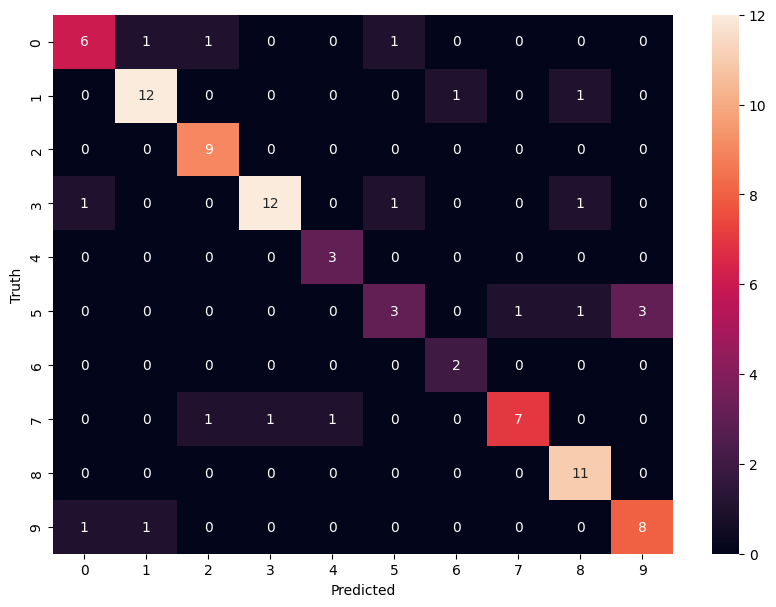

In [22]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [23]:
class_dict

{'cristiano ronaldo': 0,
 'david beckham': 1,
 'gareth bale': 2,
 'kylian mbappe': 3,
 'lionel messi': 4,
 'luis suarez': 5,
 'mohamed salah': 6,
 'neymar jr': 7,
 'thomas muller': 8,
 'zlatan ibrahimovic': 9}